In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
# from nupic.research.frameworks.pytorch.models.le_sparse_net import (
#     LeSparseNet
# )
from nupic.research.frameworks.continuous_learning.utils import clear_labels
from exp_lesparse import LeSparseNet

from nupic.torch.modules import (
    Flatten,
    KWinners,
    KWinners2d,
    SparseWeights,
    SparseWeights2d,
)

from nupic.research.frameworks.pytorch.model_utils import evaluate_model
from nupic.research.frameworks.continuous_learning.dendrite_layers import DendriteLayer, DendriteInput, DendriteOutput
# from nupic.research.frameworks.continuous_learning.utils import ADA_fun

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [61]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)
    
cnn_pct_on = (0.25, 0.125) # default
cnn_weight_sparsity = (0.3, 0.2) # default

cnn_out = (512,512)

def adjust_sparsity(layer_size, pct_on):
    return max(pct_on/(layer_size/64), 0.02)

exp = "sparseCNN2"
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["cnn_out_channels"] = (cnn_out[0], cnn_out[1])
config["cnn_percent_on"] = (adjust_sparsity(cnn_out[0],cnn_pct_on[0]), adjust_sparsity(cnn_out[1], cnn_pct_on[1]))
config["cnn_weight_sparsity"] = (adjust_sparsity(cnn_out[0],cnn_weight_sparsity[0]),
                                 adjust_sparsity(cnn_out[1],cnn_weight_sparsity[1]))
config["batch_size"] = 32

config["boost_strength"] = 0.0
config["boost_strength_factor"] = 0.0
config["duty_cycle_period"] = 1000000

experiment = ContinuousSpeechExperiment(config)

Creating optimizer with learning rate= 0.01


In [62]:
train_inds = np.arange(1,11).reshape(5,2)
layer_type = "kwinner"
dcs = []
for j in range(len(train_inds)):
    print(j)
    experiment.train(1,train_inds[j],
                    freeze_output=True,
                    layer_type=layer_type,
                    output_indices=clear_labels(train_inds[j]))
    dcs.append(experiment.get_duty_cycles())
    

0
1
2
3
4


In [58]:
experiment.get_auc()

76.54899999999999

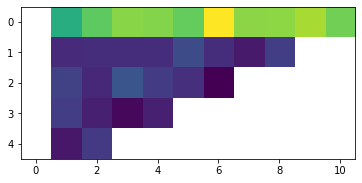

In [59]:
fc = experiment.get_forgetting_curve()
plt.imshow(fc)

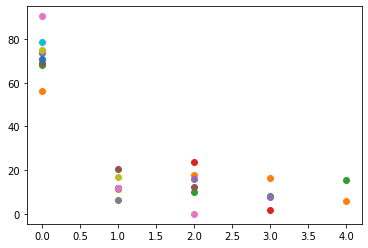

In [60]:
plt.plot(fc,'o');

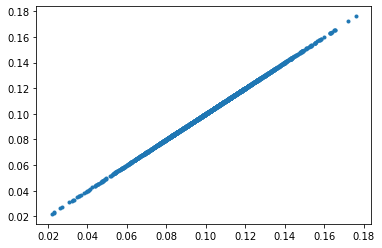

In [18]:
a = torch.squeeze(dcs[0]["linear1_kwinners"]).cpu().numpy()
b = torch.squeeze(dcs[4]["linear1_kwinners"]).cpu().numpy()
plt.plot(a,b,'.')

In [11]:
def get_dcs(dcs, epoch):
    keys, vals = list(dcs[epoch].keys()), list(dcs[epoch].values())
    def squeeze_and_transfer(x):
        return torch.squeeze(x).cpu().numpy()
    
    return {keys[k]: squeeze_and_transfer(vals[k]) for k in range(len(keys))}

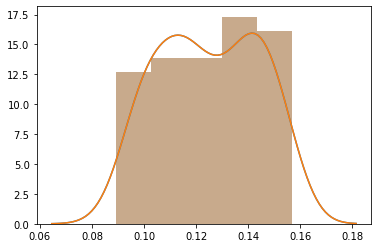

In [22]:
sns.distplot(get_dcs(dcs, 1)["cnn2_kwinner"], kde=True)
sns.distplot(get_dcs(dcs, 4)["cnn2_kwinner"], kde=True)


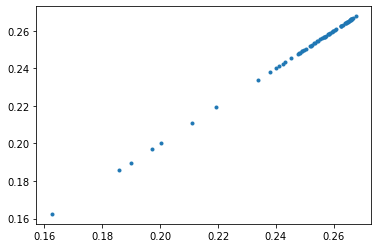

In [20]:
plt.plot(get_dcs(dcs,4)["cnn1_kwinner"], get_dcs(dcs,3)["cnn1_kwinner"],'.')

In [7]:
a =np.vstack(experiment.running_accuracy)

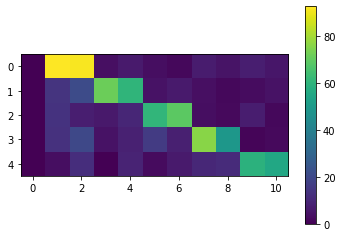

In [8]:
plt.imshow(a)
plt.colorbar();

In [ ]:
83, 75, 78

In [ ]:
80, 73

In [ ]:
experiment.train_entire_dataset(1)
experiment.test()

In [6]:
a =np.vstack(experiment.running_accuracy)

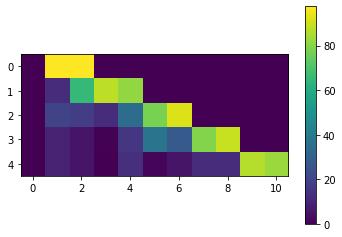

In [10]:
plt.imshow(a)
plt.colorbar();

In [8]:
b = np.vstack([np.roll(a[i,:], 8-2*i) for i in range(a.shape[0])])

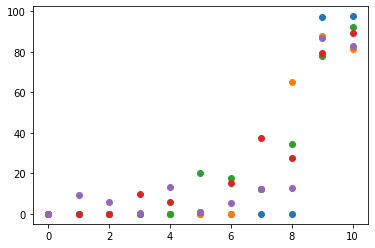

In [9]:
plt.plot(b.T,'o')

In [3]:
experiment.model

LeSparseNet(
  (cnn1_cnn): SparseWeights2d(
    weight_sparsity=0.3
    (module): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn1_kwinner): KWinners2d(channels=64, local=False, n=0, percent_on=0.25, boost_strength=1.5, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_cnn): SparseWeights2d(
    weight_sparsity=0.2
    (module): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn2_kwinner): KWinners2d(channels=64, local=False, n=0, percent_on=0.125, boost_strength=1.5, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()


In [42]:
dcs

[{'cnn1_kwinner': tensor([[[[0.0790]],
  
           [[0.0788]],
  
           [[0.0782]],
  
           [[0.0799]],
  
           [[0.0789]],
  
           [[0.0758]],
  
           [[0.0359]],
  
           [[0.0309]],
  
           [[0.0623]],
  
           [[0.0769]],
  
           [[0.0761]],
  
           [[0.0370]],
  
           [[0.0636]],
  
           [[0.0313]],
  
           [[0.0882]],
  
           [[0.0686]],
  
           [[0.0489]],
  
           [[0.0794]],
  
           [[0.0556]],
  
           [[0.0349]],
  
           [[0.0786]],
  
           [[0.0310]],
  
           [[0.0439]],
  
           [[0.0776]],
  
           [[0.0574]],
  
           [[0.0815]],
  
           [[0.0778]],
  
           [[0.0496]],
  
           [[0.0500]],
  
           [[0.0772]],
  
           [[0.0335]],
  
           [[0.0539]],
  
           [[0.0775]],
  
           [[0.0327]],
  
           [[0.0818]],
  
           [[0.0785]],
  
           [[0.0805]],
  
           [[0.0224]],